In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
pd.options.display.max_columns = 100

In [2]:
cont_palette = "RdBu"
disc_palette = "Set2"

In [53]:
season = 2020
season_df = pd.read_csv(f"data/{season}.csv")
season_df.tail()

,game_id,inning,top,home_score,away_score,outs,pitcher_name,pitcher_id,pitcher_lefty,batter_name,batter_id,batter_lefty,runner_1,runner_2,runner_3,balls,strikes,pitch_type,at_bat,raw_pitch_type,count,pitch_type_lag_1,pitch_type_lag_2,pitch_count,nth_season_pitch,fastball_rate,sinker_rate,slider_rate,changeup_rate,knuckle_curve_rate,curveball_rate,cutter_rate,splitter_rate,other_rate
263839,630592,9,True,6,3,1,Cole Sulser,642121,False,Ji-Man Choi,596847,True,False,False,False,0,1,fastball,75,Four-Seam Fastball,"(0,1)",fastball,none,9,413,0.578692,0.0,0.167070,0.251816,0.0,0.0,0.0,0.0,0.002421
263840,630592,9,True,6,3,1,Cole Sulser,642121,False,Ji-Man Choi,596847,True,False,False,False,0,2,fastball,75,Four-Seam Fastball,"(0,2)",fastball,fastball,10,414,0.579710,0.0,0.166667,0.251208,0.0,0.0,0.0,0.0,0.002415
263841,630592,9,True,6,3,1,Cole Sulser,642121,False,Ji-Man Choi,596847,True,False,False,False,1,2,changeup,75,Changeup,"(1,2)",fastball,fastball,11,415,0.578313,0.0,0.166265,0.253012,0.0,0.0,0.0,0.0,0.002410
263842,630592,9,True,6,3,1,Cole Sulser,642121,False,Ji-Man Choi,596847,True,False,False,False,2,2,changeup,75,Changeup,"(2,2)",changeup,fastball,12,416,0.576923,0.0,0.165865,0.254808,0.0,0.0,0.0,0.0,0.002404
263843,630592,9,True,6,3,2,Cole Sulser,642121,False,Brandon Lowe,664040,True,False,False,False,0,0,changeup,76,Changeup,"(0,0)",none,none,13,417,0.575540,0.0,0.165468,0.256595,0.0,0.0,0.0,0.0,0.002398


# Overall Pitch Distribution

In [54]:
pitch_frequencies = 100*season_df.pitch_type.value_counts(True)
pitch_orders = dict(zip(pitch_frequencies.index, range(len(pitch_frequencies))))

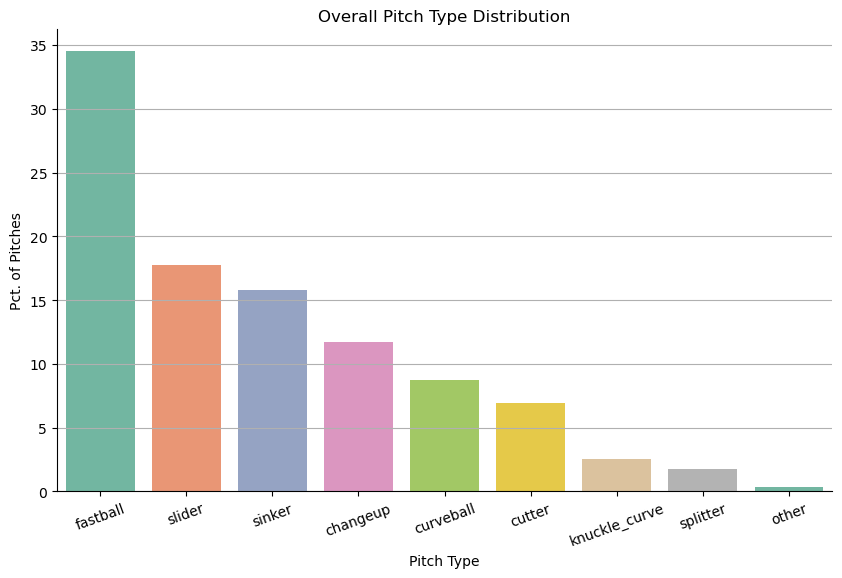

In [55]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=pitch_frequencies.index, y=pitch_frequencies.values, palette=disc_palette)
ax.grid(axis='y')
ax.set(xlabel="Pitch Type", ylabel="Pct. of Pitches", title="Overall Pitch Type Distribution")
plt.xticks(rotation=20)
sns.despine()

# Spread in Pitch Distribution by Pitcher

In [56]:
pitches_by_pitcher = season_df.pitcher_name.value_counts()
types_by_pitcher = season_df.groupby('pitcher_name')['pitch_type'].apply(lambda x: 100*x.value_counts(True)).reset_index()
types_by_pitcher.rename(columns={'level_1': 'pitch_type', 'pitch_type': 'freq'}, inplace=True)
types_by_pitcher = types_by_pitcher.loc[types_by_pitcher['pitcher_name'].map(pitches_by_pitcher) >= 100].copy(deep=True) # remove pitchers with < 100 pitches


In [57]:
types_by_pitcher_common = types_by_pitcher.loc[types_by_pitcher['pitcher_name'].isin(pitches_by_pitcher.index[:10])].copy(deep=True)
types_by_pitcher_common.sort_values('pitch_type', key=lambda x: [pitch_orders[pitch] for pitch in x], inplace=True)
types_by_pitcher_common.head()

,pitcher_name,pitch_type,freq
38,Aaron Nola,fastball,24.221453
2801,Trevor Bauer,fastball,47.219846
2588,Shane Bieber,fastball,37.802908
1032,German Marquez,fastball,38.499184
27,Aaron Civale,fastball,2.497918


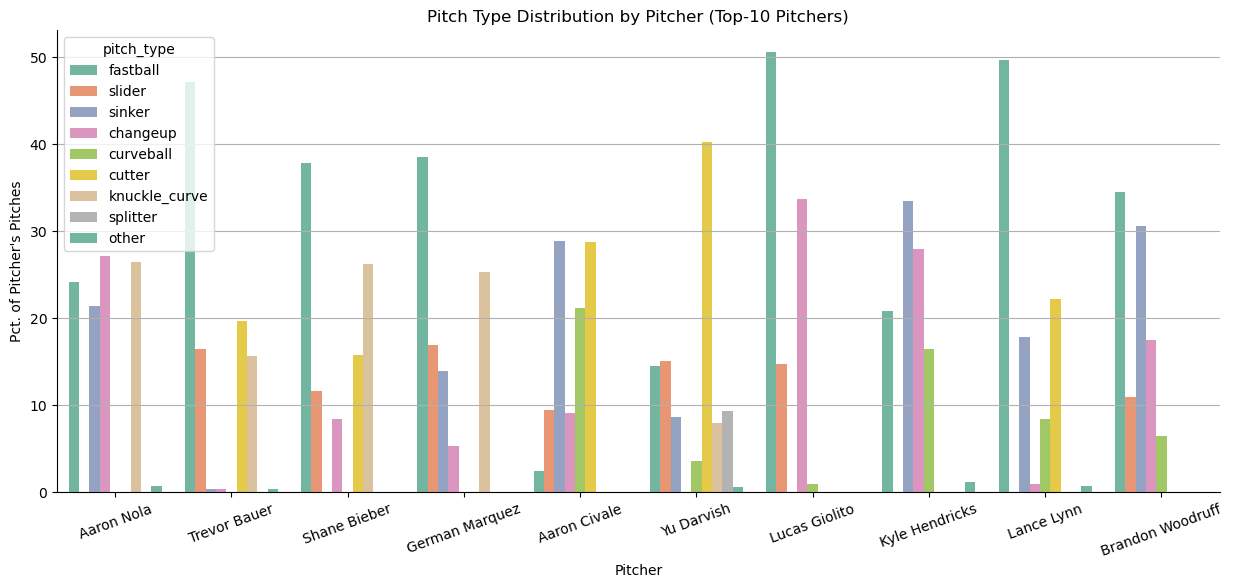

In [58]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(data=types_by_pitcher_common, hue='pitch_type', y='freq', x='pitcher_name', palette=disc_palette)
ax.grid(axis='y')
ax.set(xlabel="Pitcher", ylabel="Pct. of Pitcher's Pitches", title="Pitch Type Distribution by Pitcher (Top-10 Pitchers)")
ax.tick_params(axis='x', rotation=20)
sns.despine()


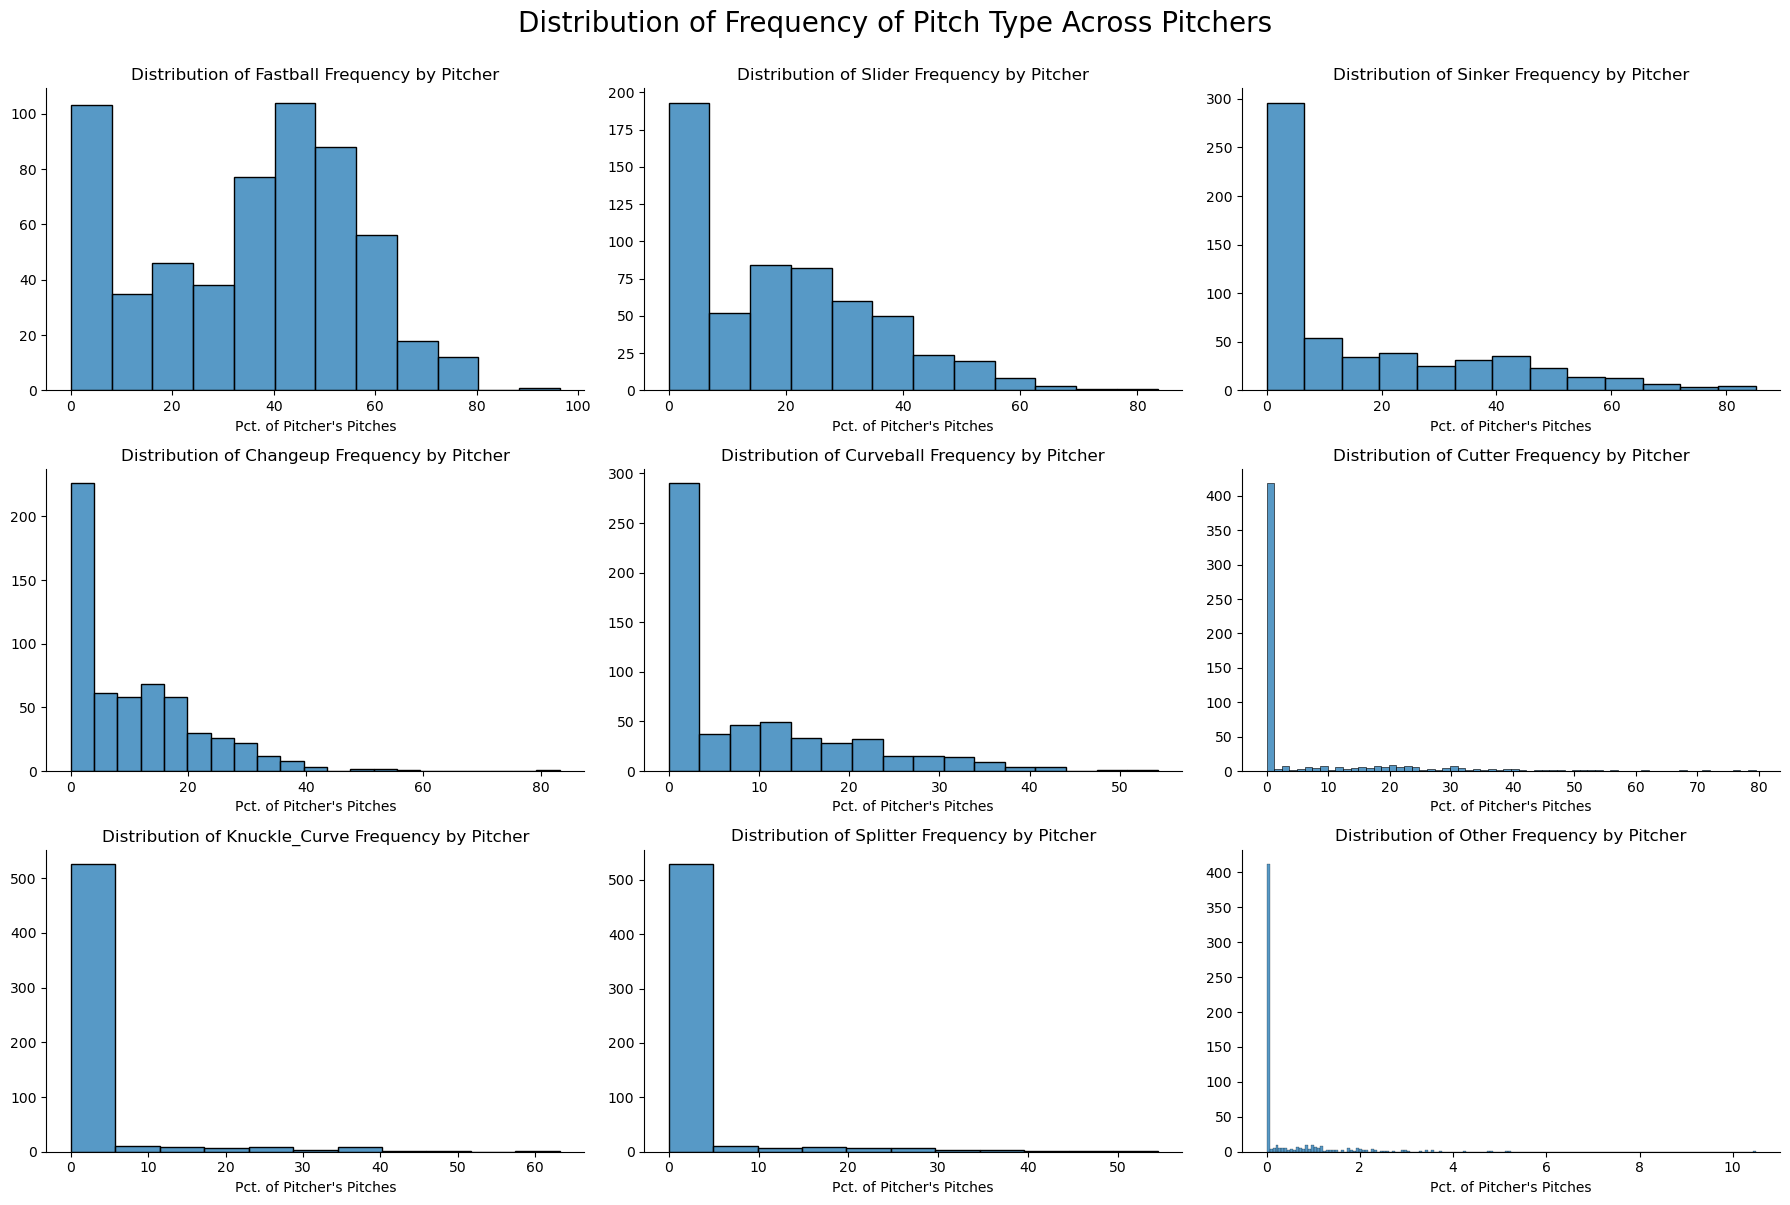

In [59]:
types_by_pitcher_pivoted = types_by_pitcher.pivot(index="pitcher_name", columns="pitch_type", values="freq").fillna(0)
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
for i, ax in enumerate(axes.ravel()):
    pitch = list(pitch_orders)[i]
    sns.histplot(types_by_pitcher_pivoted[pitch], ax=ax)
    ax.set(xlabel="Pct. of Pitcher's Pitches", ylabel="", title=f"Distribution of {pitch.title()} Frequency by Pitcher")
sns.despine()
plt.suptitle("Distribution of Frequency of Pitch Type Across Pitchers", size=20, y=1)
plt.tight_layout()


# Pitch Distribution by Count

In [60]:
types_by_count = season_df.groupby('count')['pitch_type'].apply(lambda x: 100*x.value_counts(True)).reset_index()
types_by_count.rename(columns={'level_1': 'pitch_type', 'pitch_type': 'freq'}, inplace=True)
types_by_count['balls'] = types_by_count['count'].apply(lambda x: x[1]).astype(int)
types_by_count['strikes'] = types_by_count['count'].apply(lambda x: x[-2]).astype(int)
types_by_count.sort_values(['balls', 'strikes'], inplace=True)
types_by_count.drop(columns=['balls', 'strikes'], inplace=True)
types_by_count.head()


,count,pitch_type,freq
0,"(0,0)",fastball,36.149106
1,"(0,0)",sinker,18.529986
2,"(0,0)",slider,16.075455
3,"(0,0)",curveball,10.635803
4,"(0,0)",changeup,7.805501


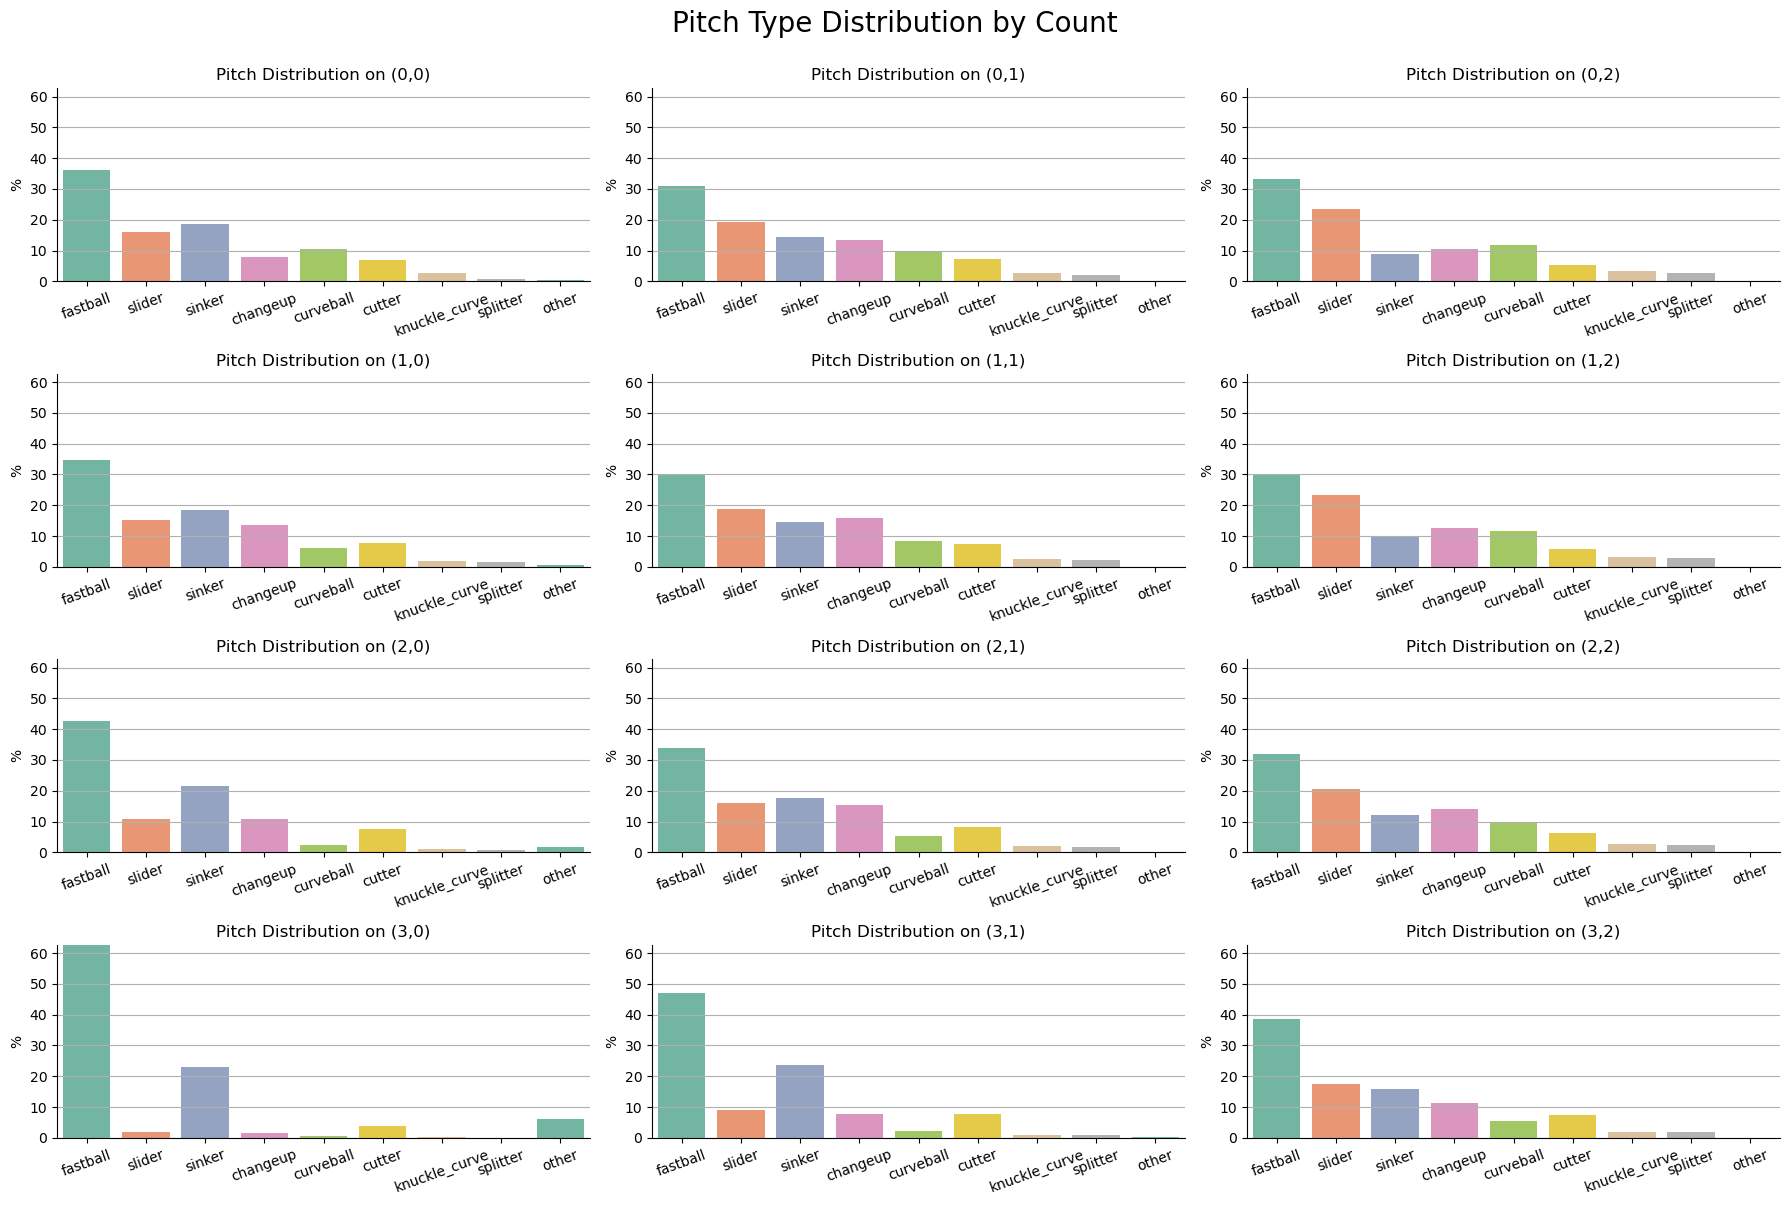

In [61]:
types_by_count_pivoted = types_by_count.pivot(index="count", columns="pitch_type", values="freq").fillna(0)
fig, axes = plt.subplots(4, 3, figsize=(18, 12))
for i, ax in enumerate(axes.ravel()):
    count = types_by_count_pivoted.index[i]
    count_distribution = types_by_count_pivoted.loc[count].sort_index(key=lambda x: [pitch_orders[pitch] for pitch in x])
    sns.barplot(x=count_distribution.index, y=count_distribution.values, ax=ax, palette=disc_palette)
    ax.set(title=f"Pitch Distribution on {count}", ylabel="%", xlabel="")
    ax.set(ylim=(0, (types_by_count_pivoted.values).max()))
    ax.grid(axis='y')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
    ax.yaxis.set_major_locator(mticker.MultipleLocator(10))
sns.despine()
plt.suptitle("Pitch Type Distribution by Count", size=20, y=1)
plt.tight_layout()


# Pitch Distribution by Score

In [62]:
by_score = season_df.copy(deep=True)
by_score['leading_team'] = "Pitching Team"
by_score.loc[(by_score['home_score'] == by_score['away_score']), 'leading_team'] = "Tied"
by_score.loc[(by_score['away_score'] > by_score['home_score']) & by_score['top'], 'leading_team'] = "Batting Team"
by_score.loc[(by_score['home_score'] > by_score['away_score']) & ~by_score['top'], 'leading_team'] = "Batting Team"


In [63]:
types_by_lead = by_score.groupby('leading_team')['pitch_type'].apply(lambda x: 100*x.value_counts(True)).reset_index()
types_by_lead.rename(columns={'level_1': 'pitch_type', 'pitch_type': 'freq'}, inplace=True)


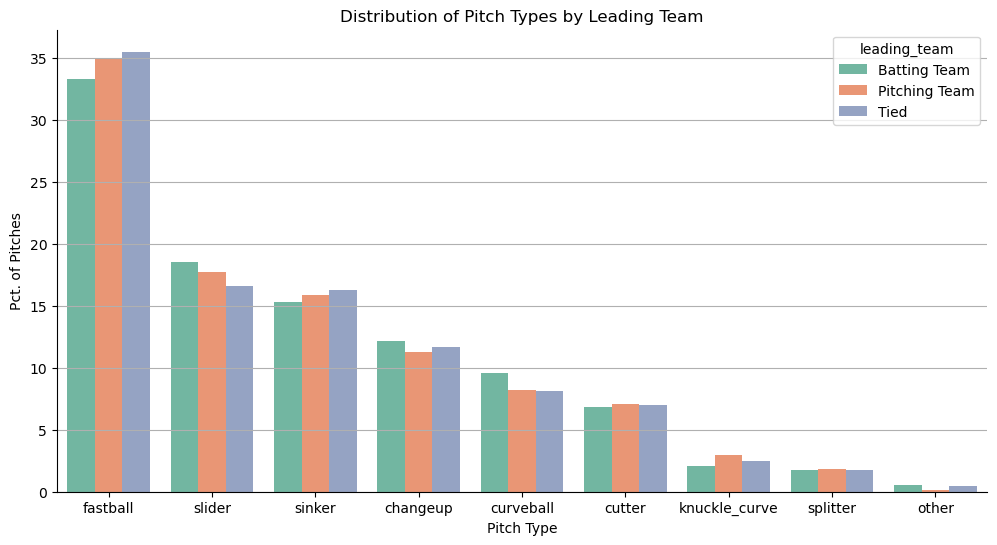

In [64]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=types_by_lead, x='pitch_type', y='freq', hue='leading_team', palette=disc_palette)
ax.grid(axis='y')
ax.set(xlabel="Pitch Type", ylabel="Pct. of Pitches", title="Distribution of Pitch Types by Leading Team")
sns.despine()


______

#### SCRATCH

In [65]:
pitcher_counts = season_df.pitcher_name.value_counts()
pitcher = pitcher_counts.index[1]

In [66]:
p = season_df.loc[season_df['pitcher_name'] == pitcher].copy(deep=True)

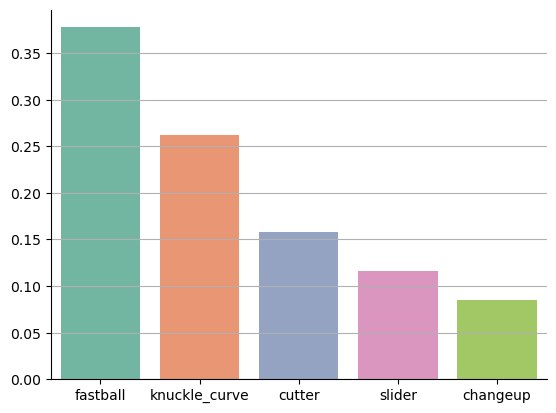

In [67]:
pt = p.pitch_type.value_counts(True)
fig, ax = plt.subplots()
sns.barplot(x=pt.index, y=pt.values, palette=disc_palette)
ax.grid(axis='y')
sns.despine()


In [68]:
vcs = season_df.groupby('pitcher_name')['pitch_type'].value_counts(True)
vcs.name = 'freq'
vcs = vcs.reset_index()
vcs


,pitcher_name,pitch_type,freq
0,A.J. Cole,slider,0.444724
1,A.J. Cole,fastball,0.336683
2,A.J. Cole,cutter,0.095477
3,A.J. Cole,changeup,0.077889
4,A.J. Cole,curveball,0.025126
...,...,...,...
3076,Zack Wheeler,sinker,0.223757
3077,Zack Wheeler,slider,0.157459
3078,Zack Wheeler,curveball,0.100368
3079,Zack Wheeler,changeup,0.084715


In [75]:
vcs.loc[vcs['freq'] >= 0.01].pitcher_name.value_counts().value_counts()

4    262
5    194
3    174
2     60
6     28
1     10
7      4
8      1
Name: pitcher_name, dtype: int64

In [127]:
n_pitches_by_pitcher = vcs.loc[vcs['freq'] >= .01].pitcher_name.value_counts()
arsenal_4 = n_pitches_by_pitcher.loc[n_pitches_by_pitcher == 3]
arsenal_4

T.J. McFarland     3
Reggie McClain     3
Rex Brothers       3
Amir Garrett       3
Trevor Richards    3
                  ..
Caleb Baragar      3
Kevin Ginkel       3
Kyle McGowin       3
Ben Braymer        3
Paul Fry           3
Name: pitcher_name, Length: 174, dtype: int64

In [128]:
(vcs.loc[vcs['pitcher_name'].isin(arsenal_4.index) & (vcs.freq >= .01)].pitch_type.value_counts() / len(arsenal_4.index.unique())).round(2)

fastball         0.82
slider           0.75
changeup         0.57
sinker           0.32
curveball        0.28
cutter           0.10
splitter         0.06
knuckle_curve    0.05
other            0.04
Name: pitch_type, dtype: float64

In [134]:
vcs.loc[(vcs['pitcher_name'] == arsenal_4.sample(1, random_state=125).index[0])]


,pitcher_name,pitch_type,freq
46,Adam Cimber,slider,0.491525
47,Adam Cimber,fastball,0.282486
48,Adam Cimber,sinker,0.225989


In [131]:
vcs.loc[(vcs['pitcher_name'].isin(arsenal_4.index)) & (vcs.freq >= .01)].groupby('pitcher_name').apply(lambda x: " / ".join(sorted(x['pitch_type']))).value_counts(True).head(10)


changeup / fastball / slider       0.321839
fastball / sinker / slider         0.137931
changeup / curveball / fastball    0.097701
changeup / sinker / slider         0.091954
curveball / fastball / slider      0.074713
fastball / slider / splitter       0.034483
curveball / cutter / fastball      0.034483
fastball / other / slider          0.022989
cutter / sinker / slider           0.017241
changeup / curveball / slider      0.017241
dtype: float64

In [ ]:
fastball, slider, curveball, changeup
fastball, slider, sinker, changeup
fastball, sinker, curveball, changeup
fastball, cutter, curveball, changeup

In [136]:
season_df.loc[season_df['pitcher_name'] == "Adam Cimber"].pitch_type.value_counts()

slider      87
fastball    50
sinker      40
Name: pitch_type, dtype: int64